Could not import SolaraViz. If you need it, install with 'pip install --pre mesa[viz]'


/usr/local/anaconda3/envs/pil_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Normal Gravity with Competing Sweet Spots


/var/folders/_3/bg4ltz5x7nx864wk66d7w3sr0000gn/T/ipykernel_19889/1572587134.py:100: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


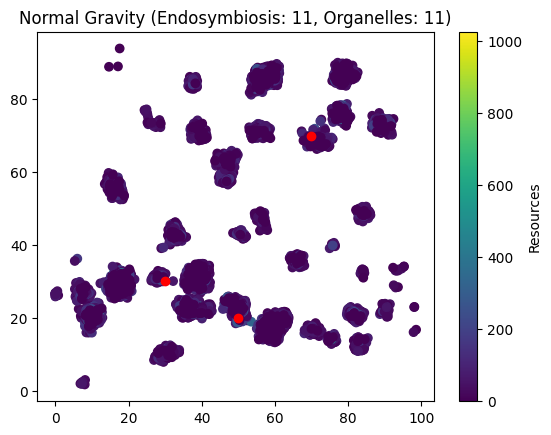

Endosymbiosis Events: 11, Organelle Agents: 11, Avg Resources: 105.50, Avg Motility: 0.92, Avg Efficiency: 1.27, Population: 13334

Microgravity


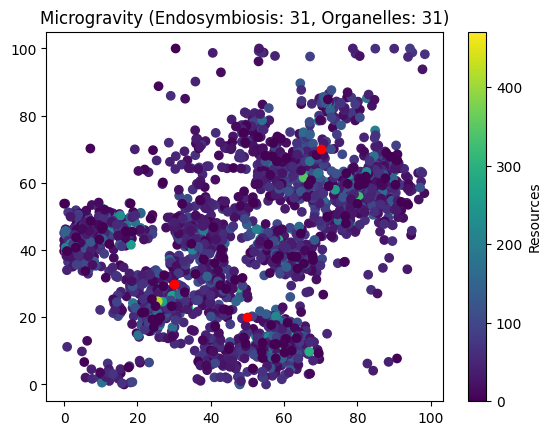

Endosymbiosis Events: 31, Organelle Agents: 31, Avg Resources: 58.09, Avg Motility: 1.03, Avg Efficiency: 1.43, Population: 2279


In [1]:
import numpy as np
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import ContinuousSpace
import matplotlib.pyplot as plt
import random

# Gravitational centers (position, strength) for sweet spots
GRAVITY_CENTERS = [
    (np.array([30, 30]), 1.0),  # Strongest sweet spot
    (np.array([70, 70]), 0.7),  # Medium sweet spot
    (np.array([50, 20]), 0.5)   # Weakest sweet spot
]
G_NORMAL = 0.1  # Scaled gravitational constant
G_MICRO = 0     # Microgravity

class PreyAgent(Agent):
    def __init__(self, unique_id, model):
        self.unique_id = unique_id
        self.model = model
        self.pos = None
        self.resources = 5

    def step(self):
        if self.model.G != G_MICRO:
            nearest_pos, strength = min(
                GRAVITY_CENTERS, key=lambda m: np.linalg.norm(self.pos - m[0])
            )
            r = np.linalg.norm(self.pos - nearest_pos)
            if r > 0:
                force = self.model.G * strength * 0.05 / (r**2)
                direction = (nearest_pos - self.pos) / r
                vortex = np.array([-direction[1], direction[0]]) * 0.1
                self.pos += (direction * force + vortex) * 0.1
        self.pos = np.clip(self.pos, 0, 99.999)  # Adjusted upper bound

class PredatorAgent(Agent):
    def __init__(self, unique_id, model):
        self.unique_id = unique_id
        self.model = model
        self.pos = None
        self.resources = 0
        self.motility = np.random.uniform(0.5, 1.5)
        self.efficiency = np.random.uniform(0.5, 1.5)
        self.has_organelle = False

    def step(self):
        # Movement
        if self.model.G != G_MICRO:
            nearest_pos, strength = min(
                GRAVITY_CENTERS, key=lambda m: np.linalg.norm(self.pos - m[0])
            )
            r = np.linalg.norm(self.pos - nearest_pos)
            if r > 0:
                force = self.model.G * strength / (r**2)
                direction = (nearest_pos - self.pos) / r
                vortex = np.array([-direction[1], direction[0]]) * 0.2
                self.pos += (direction * force + vortex) * self.motility * 0.1
        else:
            self.pos += np.random.uniform(-1.0, 1.0, 2)

        # Resource consumption
        nearest_pos, _ = min(GRAVITY_CENTERS, key=lambda m: np.linalg.norm(self.pos - m[0]))
        r = np.linalg.norm(self.pos - nearest_pos)
        resource_density = max(0, 10 - r / 5)
        gravity_factor = 0.5 if self.model.G == G_MICRO else 1.0
        self.resources += resource_density * self.efficiency * gravity_factor

        # Endosymbiosis
        neighbors = self.model.space.get_neighbors(self.pos, 2, include_center=False)
        for neighbor in neighbors:
            if isinstance(neighbor, PreyAgent) and not self.has_organelle:
                self.has_organelle = True
                self.resources += neighbor.resources
                self.efficiency *= 1.5
                self.model.space.remove_agent(neighbor)
                self.model.schedule.remove(neighbor)
                self.model.endosymbiosis_events += 1
                break

        # Reproduction
        if self.resources > 50 and random.random() < 0.1:
            offspring = PredatorAgent(self.model.next_id(), self.model)
            offspring.motility = self.motility + np.random.uniform(-0.1, 0.1)
            offspring.efficiency = self.efficiency + np.random.uniform(-0.1, 0.1)
            desired_pos = self.pos + np.random.uniform(-1, 1, 2)
            clipped_pos = np.clip(desired_pos, 0, 99.999)  # Adjusted upper bound
            self.model.schedule.add(offspring)
            self.model.space.place_agent(offspring, clipped_pos)
            self.resources -= 25

        self.pos = np.clip(self.pos, 0, 99.999)  # Adjusted upper bound

class GravityCompetitionModel(Model):
    def __init__(self, N_predators, N_prey, G):
        super().__init__()
        self.random = random.Random()
        self.G = G
        self.space = ContinuousSpace(100, 100, torus=False)
        self.schedule = RandomActivation(self)
        self.endosymbiosis_events = 0
        self.next_id_val = N_predators + N_prey

        for i in range(N_predators):
            agent = PredatorAgent(i, self)
            self.schedule.add(agent)
            initial_pos = np.array([np.random.uniform(0, 99.999), np.random.uniform(0, 99.999)])
            self.space.place_agent(agent, initial_pos)

        for i in range(N_prey):
            prey = PreyAgent(N_predators + i, self)
            self.schedule.add(prey)
            initial_pos = np.array([np.random.uniform(0, 99.999), np.random.uniform(0, 99.999)])
            self.space.place_agent(prey, initial_pos)

    def next_id(self):
        self.next_id_val += 1
        return self.next_id_val - 1

    def step(self):
        self.schedule.step()

def run_simulation(gravity, label, steps=100):
    model = GravityCompetitionModel(50, 50, gravity)
    for _ in range(steps):
        model.step()

    predators = [a for a in model.schedule.agents if isinstance(a, PredatorAgent)]
    positions = [a.pos for a in predators]
    x, y = zip(*positions)
    resources = [a.resources for a in predators]
    organelle_count = sum(1 for a in predators if a.has_organelle)
    avg_motility = np.mean([a.motility for a in predators])
    avg_efficiency = np.mean([a.efficiency for a in predators])

    plt.scatter(x, y, c=resources, cmap="viridis")
    plt.colorbar(label="Resources")
    for pos, _ in GRAVITY_CENTERS:
        plt.plot(pos[0], pos[1], 'ro')
    plt.title(f"{label} (Endosymbiosis: {model.endosymbiosis_events}, Organelles: {organelle_count})")
    plt.show()

    return {
        "endosymbiosis_events": model.endosymbiosis_events,
        "organelle_agents": organelle_count,
        "avg_resources": np.mean(resources),
        "avg_motility": avg_motility,
        "avg_efficiency": avg_efficiency,
        "population": len(predators)
    }

# Run simulations
print("Normal Gravity with Competing Sweet Spots")
normal_results = run_simulation(G_NORMAL, "Normal Gravity")
print(f"Endosymbiosis Events: {normal_results['endosymbiosis_events']}, "
      f"Organelle Agents: {normal_results['organelle_agents']}, "
      f"Avg Resources: {normal_results['avg_resources']:.2f}, "
      f"Avg Motility: {normal_results['avg_motility']:.2f}, "
      f"Avg Efficiency: {normal_results['avg_efficiency']:.2f}, "
      f"Population: {normal_results['population']}")

print("\nMicrogravity")
micro_results = run_simulation(G_MICRO, "Microgravity")
print(f"Endosymbiosis Events: {micro_results['endosymbiosis_events']}, "
      f"Organelle Agents: {micro_results['organelle_agents']}, "
      f"Avg Resources: {micro_results['avg_resources']:.2f}, "
      f"Avg Motility: {micro_results['avg_motility']:.2f}, "
      f"Avg Efficiency: {micro_results['avg_efficiency']:.2f}, "
      f"Population: {micro_results['population']}")

Findings suggest two distinct paths to complexity:

1. Microgravity: Frequent, smaller adaptations driven by necessity (e.g., more endosymbiosis with modest benefits).
2. Normal Gravity: Slower, less frequent adaptations that might yield bigger payoffs (e.g., rarer endosymbiosis with greater efficiency gains).